<a href="https://colab.research.google.com/github/LugenderGeist/computer_vision_4/blob/main/computer_vision_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Пути к папкам с изображениями
healthy_brain_dir = '/content/drive/MyDrive/Colab Notebooks/computer_vision/brain_images/Healthy'
tumor_brain_dir = '/content/drive/MyDrive/Colab Notebooks/computer_vision/brain_images/Tumor'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

IMG_SIZE = (128, 128)  # Размер входного изображения

# Загрузка данных
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')
        img_array = img_to_array(img) / 255.0  # Нормализация
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

healthy_images, healthy_labels = load_images_from_folder(healthy_brain_dir, 0)
tumor_images, tumor_labels = load_images_from_folder(tumor_brain_dir, 1)

# Объединение данных
X = np.concatenate((healthy_images, tumor_images), axis=0)
y = np.concatenate((healthy_labels, tumor_labels), axis=0)

# Перемешивание данных перед разделением
indices = np.arange(X.shape[0])
np.random.seed(42)
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Разделение данных на тренировочную, валидационную и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)


Training on Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5693 - loss: 1.3954 - val_accuracy: 0.5986 - val_loss: 1.2160
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.6738 - loss: 1.1965 - val_accuracy: 0.7686 - val_loss: 1.0665
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.7180 - loss: 1.0567 - val_accuracy: 0.8100 - val_loss: 0.9560
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.7585 - loss: 0.9774 - val_accuracy: 0.8257 - val_loss: 0.8695
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.8103 - loss: 0.8751 - val_accuracy: 0.8014 - val_loss: 0.8459
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.8161 - loss: 0.8207 - val_accuracy: 0.8314 - val_loss: 0.7671
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.8314 - loss: 0.7544 - val_accuracy: 0.8486 - val_loss: 0.7157
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.8582 - loss: 0.6994 - val_accuracy: 0.86

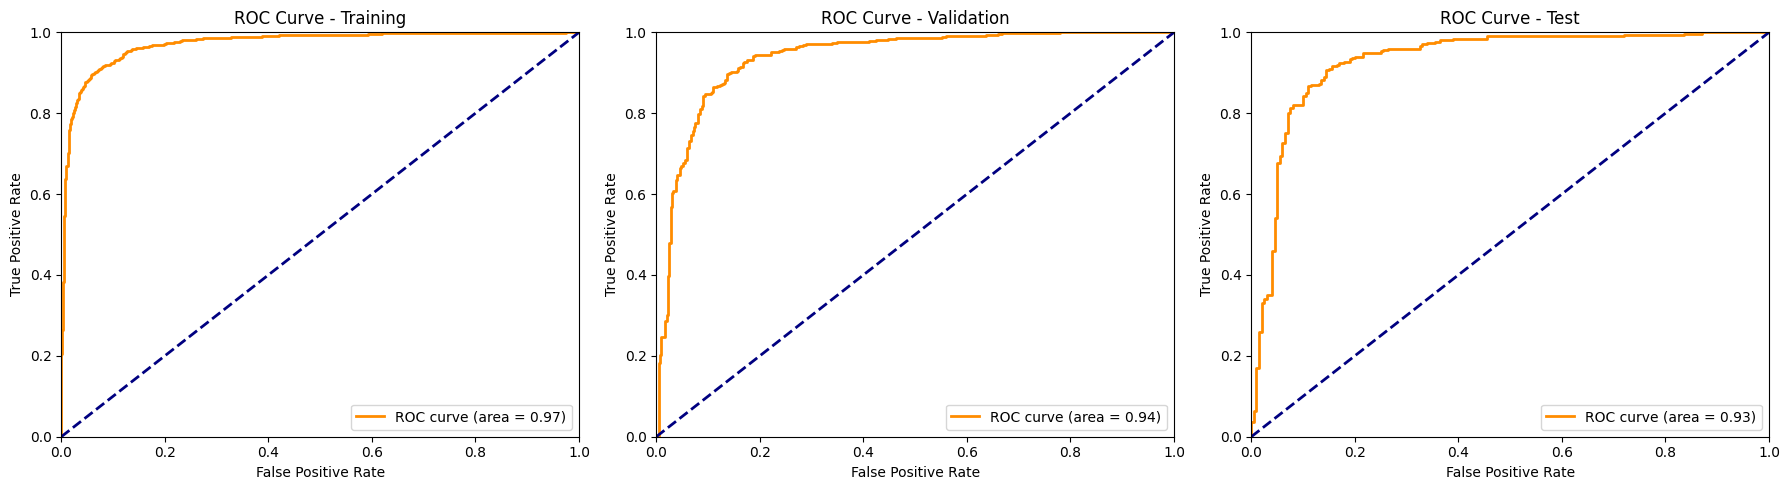

In [7]:
# Параметры

BATCH_SIZE = 32
EPOCHS = 10  # Количество эпох

# Функция для создания модели (чтобы переиспользовать её в кросс-валидации)
def create_model():
    model = Sequential([
        Flatten(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Кросс-валидация
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold кросс-валидация
fold_no = 1
accuracies = []
losses = []

for train_index, val_index in kf.split(X_train):
    print(f"Training on Fold {fold_no}")

    # Разделение данных для текущего фолда
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Создание модели
    model = create_model()

    # Обучение модели
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE
    )

    # Оценка модели на валидационной выборке текущего фолда
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    accuracies.append(val_accuracy)
    losses.append(val_loss)
    print(f"Fold {fold_no} Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")

    fold_no += 1

# Средние значения точности и потерь по всем фолдам
mean_accuracy = np.mean(accuracies)
mean_loss = np.mean(losses)
print(f"\nMean Cross-Validation Accuracy: {mean_accuracy:.4f}, Mean Cross-Validation Loss: {mean_loss:.4f}")

# Обучение финальной модели на всей тренировочной выборке
final_model = create_model()
final_history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

# Оценка финальной модели на тестовой выборке
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Предсказания
y_pred_train = final_model.predict(X_train).ravel()
y_pred_val = final_model.predict(X_val).ravel()
y_pred_test = final_model.predict(X_test).ravel()

# Функция для построения ROC-кривых горизонтально
def plot_roc_curves_horizontal(y_train, y_pred_train, y_val, y_pred_val, y_test, y_pred_test):
    # Создаем фигуру с тремя подграфиками в одну строку
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 строка, 3 столбца
    titles = ["Training", "Validation", "Test"]
    y_true_list = [y_train, y_val, y_test]
    y_pred_list = [y_pred_train, y_pred_val, y_pred_test]

    for i, ax in enumerate(axes):
        y_true = y_true_list[i]
        y_pred = y_pred_list[i]
        title = titles[i]

        # Вычисляем значения для ROC-кривой
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)

        # Строим ROC-кривую
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f"ROC Curve - {title}")
        ax.legend(loc="lower right")

    # Отображаем график
    plt.tight_layout()
    plt.show()

# Вывод метрик
def print_metrics(y_true, y_pred, title):
    y_pred_binary = (y_pred > 0.5).astype(int)
    print(f"\n{title} Metrics:")

    # Получаем отчет о метриках в виде словаря
    report = classification_report(y_true, y_pred_binary, output_dict=True)

    # Извлекаем accuracy
    accuracy = report['accuracy']
    print(f"Accuracy: {accuracy:.4f}")

    # Извлекаем precision и recall для каждого класса
    for class_label in ['0', '1']:  # Предполагается, что классы имеют метки "0" и "1"
        if class_label in report:
            precision = report[class_label]['precision']
            recall = report[class_label]['recall']
            print(f"Class {class_label}:")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall: {recall:.4f}")

    # Выводим матрицу ошибок
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred_binary))

# Вывод метрик для тренировочной, валидационной и тестовой выборок
print_metrics(y_train, y_pred_train, "Training")
print_metrics(y_val, y_pred_val, "Validation")
print_metrics(y_test, y_pred_test, "Test")

# Построение ROC-кривых горизонтально
plot_roc_curves_horizontal(y_train, y_pred_train, y_val, y_pred_val, y_test, y_pred_test)